# Plotly + LangGraph
# 📊 + 🦜🔗
This notebook is an minimal viable code to create a LangGraph Agent capable of creating Plotly Graphing Object plots.

#### NVIDIA CUDA-X for Data Science

In [1]:
# %load_ext cudf.pandas
# ~ OR ~
# import cudf.pandas
# cudf.pandas.install()
# ~ OR ~ 
# > python -m cudf.pandas app.py

# uv add cudf-cu12  OR  uv add cudf-cu13 
# to check CUDA version, run `nvidia-smi` and top-left of output

# https://developer.nvidia.com/topics/ai/data-science/cuda-x-data-science-libraries/cudf

In [2]:
# cudf.pandas will accelerte pandas on GPU
import pandas as pd
pd

<module 'pandas' from '/home/will/git/Agents-Simplified-Notebooks/.venv/lib/python3.11/site-packages/pandas/__init__.py'>

In [3]:
# using the richer Graph Objects instead of Express
# uv add plotly

import plotly.graph_objects as go

In [4]:
# Various LangGraph and LangChain libraries
# uv add langgraph langchain-openai

from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI
import langchain_core

In [5]:
# Read environment variables like NVIDIA_API_KEY= from .env 
# uv add python-dotenv

import os
from dotenv import load_dotenv

In [6]:
# === LLM setup
# build.nvidia.com
load_dotenv(override=True)

llm = ChatOpenAI(
    
    # https://build.nvidia.com/models
    model="qwen/qwen3-coder-480b-a35b-instruct",
    
    # free API key at build.nvidia.com
    # read from .env with load_dotenv
    api_key=os.getenv("NVIDIA_API_KEY"), 
    base_url="https://integrate.api.nvidia.com/v1",    

    # use lower temp to minimize reasoning loops
    temperature=0.1,

    # plotly code should not take that many tokens
    max_tokens=500,
)

In [7]:
# === Sample Data ===
df = pd.DataFrame({
    'date': pd.date_range('2024-01-01', periods=10),
    'sales': [100, 120, 115, 140, 160, 155, 180, 190, 185, 200],
    'profit': [20, 25, 23, 30, 35, 33, 40, 42, 41, 45]
})
df.head(3)

date  sales  profit
0 2024-01-01    100      20
1 2024-01-02    120      25
2 2024-01-03    115      23

# 🛠️ Tools 🛠️

This function takes the LLM output and
 - ✅ is it 🐍 ?
 - ✅ is it 📊 ?
 - ✅ have  💾 ?
 - ✅ have  💬 ?

In [8]:
# ===Tools ===
def verify_figure(code: str, prompt: str) -> str:
    """Verify the figure matches the prompt.
    (1) Is it executable 🐍 Python 🐍 ?
    (2) Does it have 'fig' variable in namespace ?
    (3) Is 'fig' instance of 📊 go.Figure 📊 ? 
    (4) Does 'fig' have 💾 data 💾 trace(s) ?
    (5) Does 'fig' have a 💬 title 💬 ?
    """
    try:

        
        # (1) Is it executable 🐍 Python 🐍 ?
        namespace = {'pd': pd, 'go': go, 'df': df}
        exec(code, namespace)
        fig = namespace.get('fig')

        
        # (2) Does it have 'fig' variable in namespace ?
        if 'fig' not in namespace:
            return "❌ Code doesn't create 'fig'"

        
        # (3) Is 'fig' instance of 📊 go.Figure 📊 ? 
        if not isinstance(namespace['fig'], go.Figure):
            return "❌ 'fig' is not a plotly graph object Figure"        

        
        # (4) Does 'fig' have 💾 data 💾 trace(s) ?
        checks = [f"✅ Figure has {len(fig.data)} trace(s)"]

        
        # (5) Does 'fig' have a 💬 title 💬 ?
        if fig.layout.title.text:
            checks.append(f"✅ Title: '{fig.layout.title.text}'")

        # Return errors encountered
        return "\n".join(checks)

        
    except Exception as e:
        # Return errors encountered
        return f"❌ Error: {str(e)}"

# 🦜🔗 LangGraph Agent 🦜🔗

This is the newer LangGraph API for building sophisticate agents  
https://www.langchain.com/langgraph

In [9]:
# === Create "Agent" (LLM w/ Tools) ===

# verify_figure() defined above
tools = [verify_figure]

# this is the new 'agent' about as simple as possible
llm_with_tools = llm.bind_tools(tools)

# the graph will use these two functions to chose path through the graph
def call_model(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

def should_continue(state: MessagesState):
    return "tools" if state["messages"][-1].tool_calls else END

# Create and compile the graph
graph = StateGraph(MessagesState)
graph.add_node("agent", call_model)
graph.add_node("tools", ToolNode(tools))
graph.add_edge(START, "agent")
graph.add_conditional_edges("agent", should_continue, ["tools", END])
graph.add_edge("tools", "agent")

agent = graph.compile(checkpointer=MemorySaver())

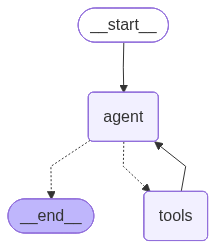

In [10]:
# Visualize Agent Graph
agent

In [11]:
# == SYSTEM MESSAGE ==
# As I was testing my agent, I added a command for each mistake the agent repeatedly made
system_msg = SystemMessage(content=f"""
Generate Python code that creates a plotly figure.

IMPORTANT: 
- DataFrame 'df' EXISTS in memory w/ columns: {list(df.columns)}
- DO create the figure using the existing 'df' variable
- DO NOT recreate the dataframe
- DO NOT wrap code in a function - write direct inline code

Requirements:
- Import plotly.graph_objects as go (NOT plotly.express)
- Create variable 'fig' using go.Figure() with go.Scatter() traces
- Use verification tools to check your code

Example format:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['date'], y=df['sales'], mode='lines'))

Return ONLY executable Python code, no function definitions.
DO NOT RETURN PROSE JUST CODE!!!
""")

In [12]:
# AGENT EXECUTOR
def agent_executor(human_prompt, thread_id):

    # You must have a config with thread_id to check conversations
    config = {"configurable": {"thread_id": thread_id}}
    result = agent.invoke({"messages": [system_msg, HumanMessage(content=prompt)]}, config=config) 


    # --- Extract the code from the AI Message --    
    # (1) Reverse loop (start at last message) through messages
    # (2) Check if message is AI Message
    # (3) Check if 'fig' in message
    # (4) Save message to 'code'
    # (5) Run the code
    # (6) Return the 'fig' object and conversation (result')

    # (1) Reverse loop (start at last message) through messages
    for message in result['messages'][::-1]:  
        # (2) Check if message is AI Message
        if (type(message) == langchain_core.messages.ai.AIMessage 
            # (3) Check if 'fig' in message
            and 'fig' in message.content):

            # (4) Save message to 'code'
            code = message.content
            break

    # (5) Run the code
    namespace = {'pd': pd, 'go': go, 'df': df}
    exec(code, namespace)

    # (6) Return the 'fig' object and conversation (result')
    return namespace['fig'], result

In [13]:
# This tracks each conversation the agent has
# It can be a string like a UUID or a number like here
thread_id = 0

### 📊 Et voilà 📊

In [ ]:
prompt = """
         Create a line plot showing sales over time.          
         Use Plotly dark theme.
         """
fig, result = agent_executor(prompt, thread_id)
fig.show()

# 💬 Inspect the Convo 💬

In [26]:
print('='*55)
for message in result['messages']:  
    print('-'*55)
    print(type(message))
    print('-'*55)
    print(message.content)
    print()
print('='*55)

-------------------------------------------------------
<class 'langchain_core.messages.system.SystemMessage'>
-------------------------------------------------------

Generate Python code that creates a plotly figure.

IMPORTANT: 
- DataFrame 'df' EXISTS in memory w/ columns: ['date', 'sales', 'profit']
- DO create the figure using the existing 'df' variable
- DO NOT recreate the dataframe
- DO NOT wrap code in a function - write direct inline code

Requirements:
- Import plotly.graph_objects as go (NOT plotly.express)
- Create variable 'fig' using go.Figure() with go.Scatter() traces
- Use verification tools to check your code

Example format:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['date'], y=df['sales'], mode='lines'))

Return ONLY executable Python code, no function definitions.
DO NOT RETURN PROSE JUST CODE!!!


-------------------------------------------------------
<class 'langchain_core.messages.human.HumanMessage'>
-------------------